In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import pandas as pd
from scipy.spatial.distance import squareform
from statsmodels.sandbox.stats.multicomp import multipletests
import numpy as np
from scipy.stats import kendalltau
import plotly.graph_objects as go


In [2]:
# @title Download the data

import os, requests, tarfile

fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]
urls = ["https://osf.io/r638s/download",
        "https://osf.io/yqb3e/download",
        "https://osf.io/ymnjv/download"]

for fname, url in zip(fnames, urls):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
          fid.write(r.content)
        print(f"Download {fname} completed!")

Download kay_labels.npy completed!
Download kay_labels_val.npy completed!
Download kay_images.npz completed!


In [3]:
with np.load(fname) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

In [4]:
stimuli = dat['stimuli']
responses = dat['responses']
roi = dat['roi']
roi_names = dat['roi_names']
stimuli_test = dat['stimuli_test']
responses_test = dat['responses_test']
print(dat.keys())
X_train, X_test, y_train, y_test = stimuli, stimuli_test, responses, responses_test

roi_names = dat['roi_names']
roi_indices = dat['roi']
roi_responses = {}

for i, roi_name in enumerate(roi_names):
    roi_mask = (roi_indices == i)
    roi_responses[roi_name] = responses[:, roi_mask]

roi_responses_test = {}
for i, roi_name in enumerate(roi_names):
    roi_mask = (roi_indices == i)
    roi_responses_test[roi_name] = responses_test[:, roi_mask]



dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])


In [5]:
roi_responses.keys()

dict_keys(['Other', 'V1', 'V2', 'V3', 'V3A', 'V3B', 'V4', 'LatOcc'])

In [6]:
roi_responses['V1']

array([[ 0.81356815,  0.80712882, -1.04932228, ..., -1.13040574,
        -0.36799363, -1.57694956],
       [-0.89468871, -1.6246709 , -0.44189263, ...,  0.24612144,
        -0.73535669,  0.86854967],
       [-1.12824869, -0.07142458,  0.36138328, ...,  0.93161792,
         0.67164379,  0.76474526],
       ...,
       [-0.51093255,  1.55392352, -0.51422032, ...,  0.0504286 ,
        -0.72627915,  0.03931598],
       [-1.08626526, -1.14839827, -0.41331365, ...,  1.87400483,
         2.20840811,  2.22554281],
       [ 1.06931569,  0.44068302, -0.06721221, ...,  0.30182604,
         0.83582291,  0.46477002]])

In [7]:
# Drop 'Other' from roi_responses
roi_responses.pop('Other', None)

array([], shape=(1750, 0), dtype=float64)

In [10]:
from google.colab import drive

drive.mount('/content/drive')

file_path = '/content/drive/My Drive/humanmade-natural.json'
chatbot_labels = pd.read_json(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Parse labels and confidence values
parsed_data = []
for entry in chatbot_labels['categories'][0]:
    if isinstance(entry, dict):
        label = entry.get("label")
        confidence = entry.get("confidence")
        if label and confidence:
            parsed_data.append({
                "label": label,
                "confidence": confidence
            })

# Get this into two arrays confidence and label
confidence = [entry["confidence"] for entry in parsed_data]
labels = [entry["label"] for entry in parsed_data]
confidence[0]='High'

<ipython-input-11-a6c08d5d471b>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for entry in chatbot_labels['categories'][0]:


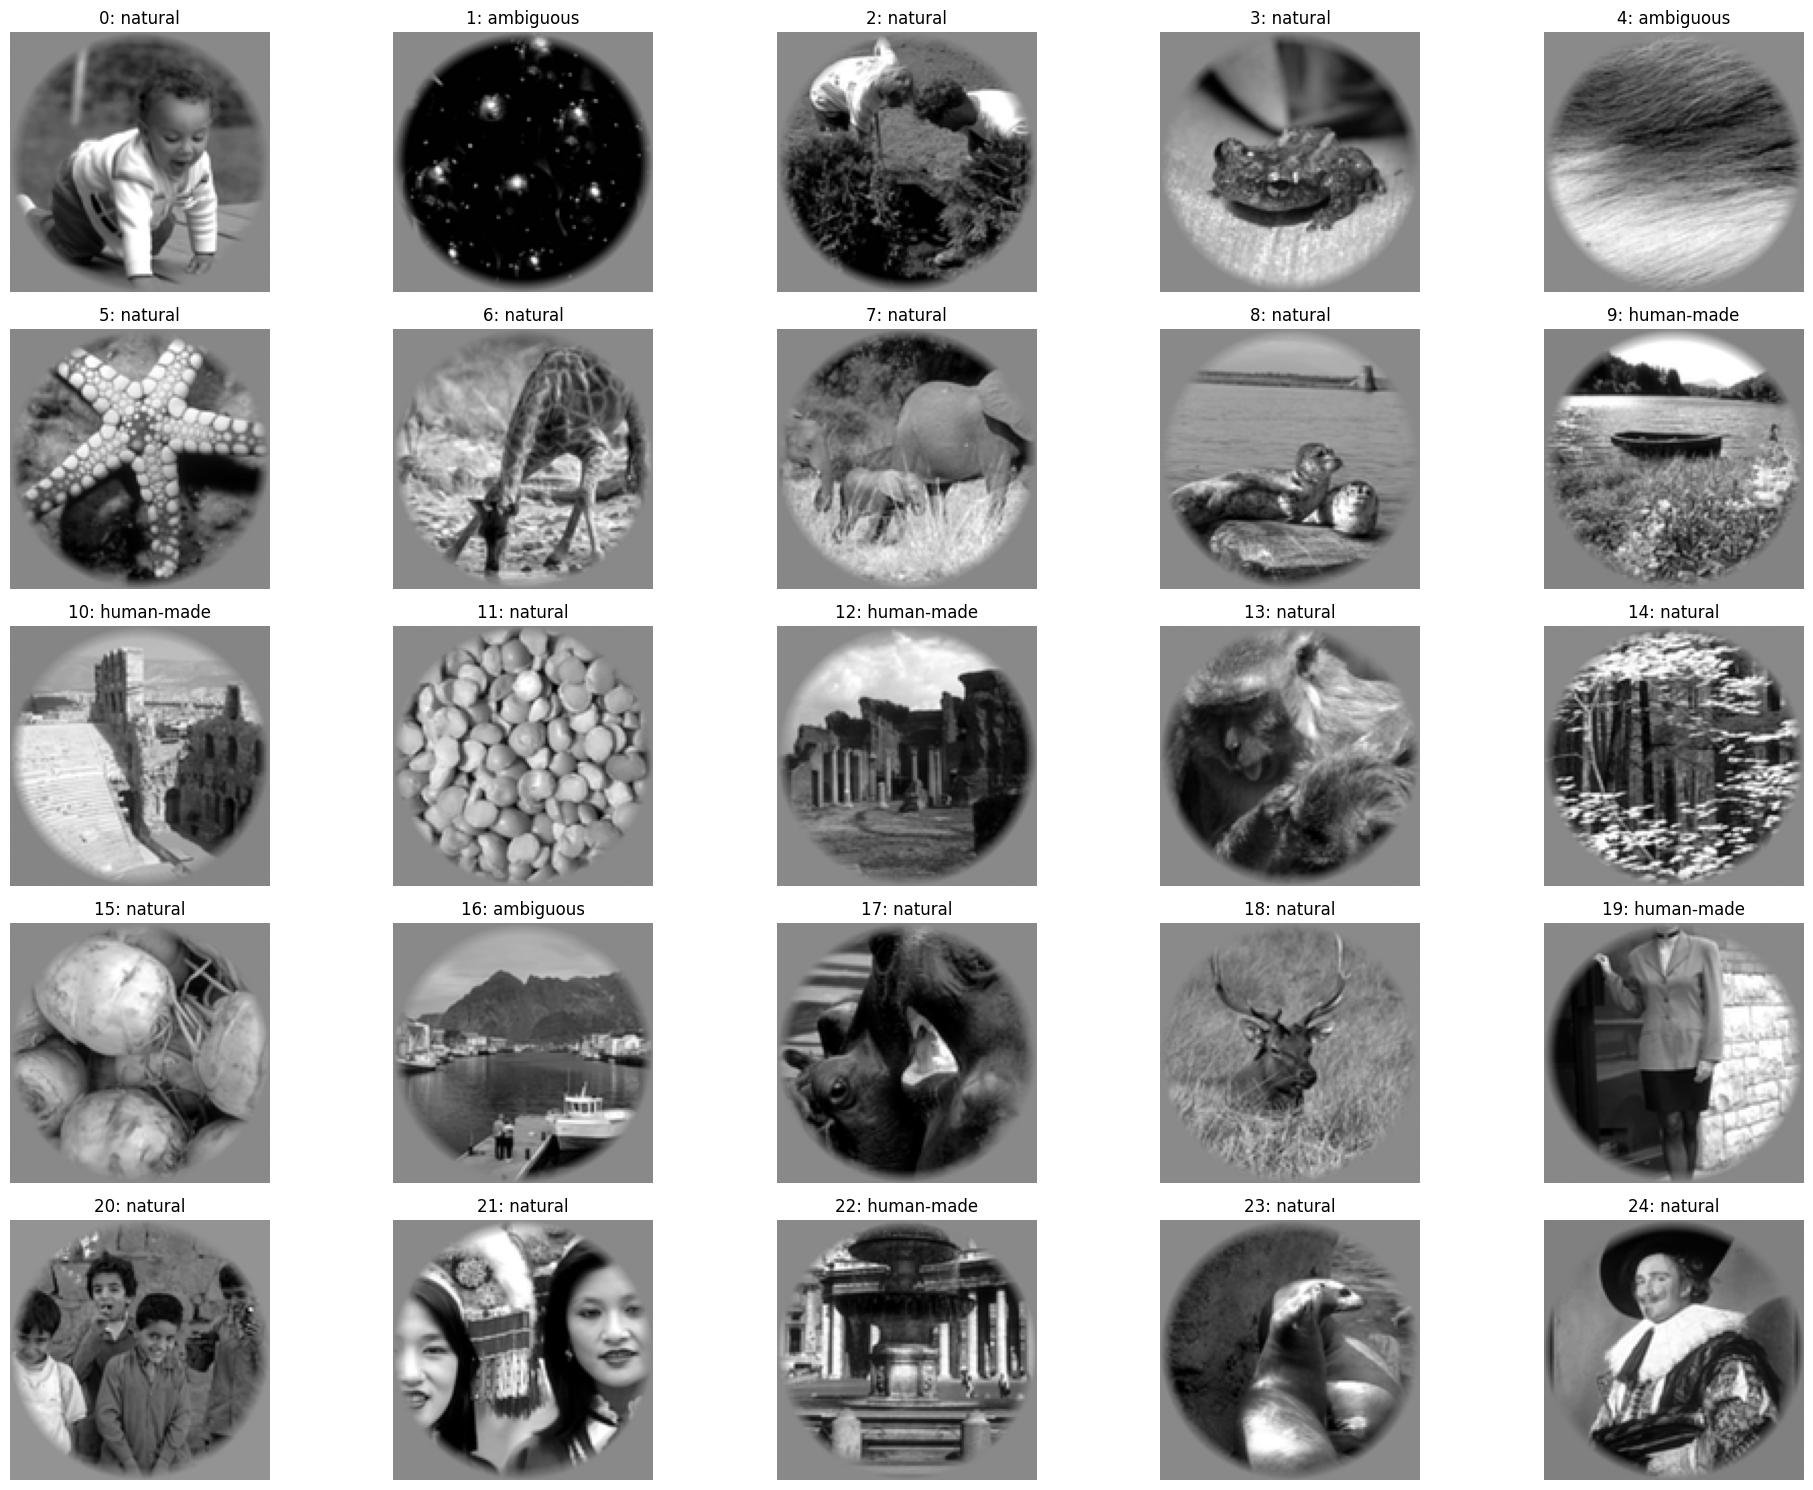

In [12]:

slider=0
plt.figure(figsize=(20, 15))
for i in range(25):
    plt.subplot(5, 5, i + 1)  # Changed to 5x5 grid for 25 images
    plt.imshow(stimuli[i + slider], cmap='gray')
    plt.title(f"{i+slider}: {labels[i + slider]}")  # Accessing labels correctly
    plt.axis('off')
plt.tight_layout()
plt.show()

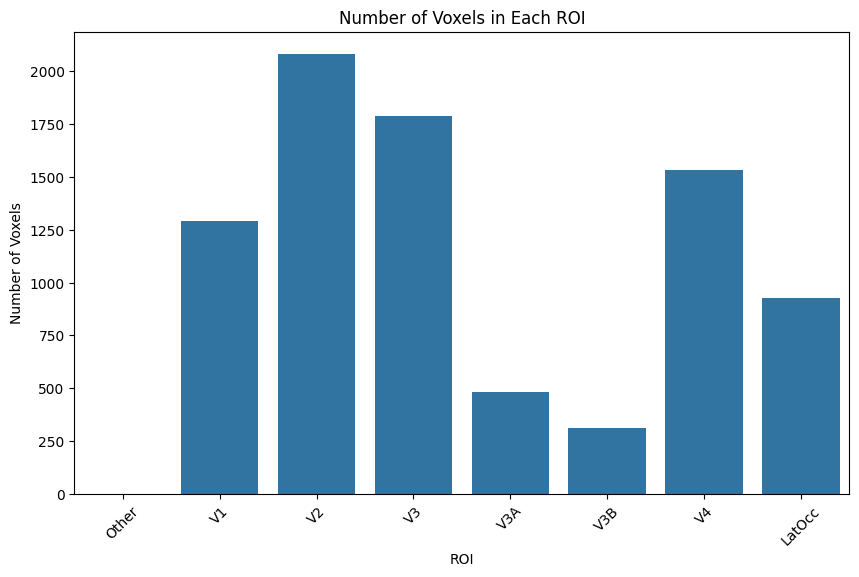

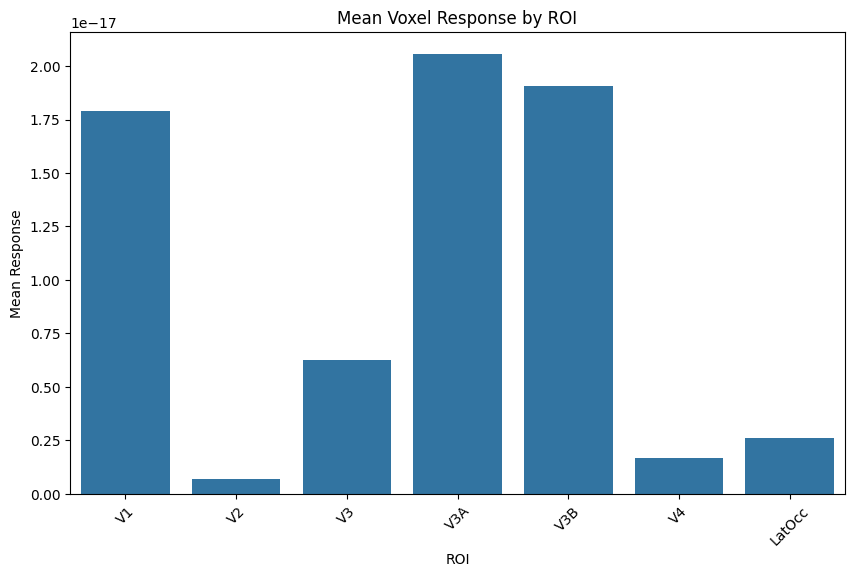

In [13]:


roi_counts = dict(zip(dat["roi_names"], np.bincount(dat["roi"])))
plt.figure(figsize=(10, 6))
sns.barplot(x=list(roi_counts.keys()), y=list(roi_counts.values()))
plt.title("Number of Voxels in Each ROI")
plt.xlabel("ROI")
plt.ylabel("Number of Voxels")
plt.xticks(rotation=45)
plt.show()

def get_roi_indices(roi_name):
    return np.where(dat["roi_names"][dat["roi"]] == roi_name)[0]

roi_mean_responses = {roi: y_train[:, get_roi_indices(roi)].mean() for roi in roi_counts.keys() if roi != 'Other'}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(roi_mean_responses.keys()), y=list(roi_mean_responses.values()))
plt.title("Mean Voxel Response by ROI")
plt.xlabel("ROI")
plt.ylabel("Mean Response")
plt.xticks(rotation=45)
plt.show()

In [14]:
parsed_data_fn = pd.DataFrame(parsed_data)

In [15]:
#give indexes to parsed data
parsed_data_fn = pd.DataFrame(parsed_data)
parsed_data_fn_train = parsed_data_fn[:1750]
parsed_data_fn_test = parsed_data_fn[1750:]
#remove columns where label is ambiguous
parsed_data_fn_train = parsed_data_fn_train[parsed_data_fn_train.label != 'ambiguous']
parsed_data_fn_test = parsed_data_fn_test[parsed_data_fn_test.label != 'ambiguous']
parsed_data_fn = parsed_data_fn[parsed_data_fn.label != 'ambiguous']



In [16]:
# Get indices from filtered DataFrames
train_indices = parsed_data_fn_train.index
test_indices = parsed_data_fn_test.index

# Filter X_train and X_test using the indices
X_train = X_train[train_indices]
X_test = X_test[test_indices - 1750]  # Adjust test indices since they start from 1750

# Create binary labels (1 for human-made, 0 for natural)
y_train = np.array([1 if label == 'human-made' else 0 for label in parsed_data_fn_train['label']])
y_test = np.array([1 if label == 'human-made' else 0 for label in parsed_data_fn_test['label']])

print(f"New shapes after filtering ambiguous entries:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

New shapes after filtering ambiguous entries:
X_train: (1693, 128, 128)
X_test: (118, 128, 128)
y_train: (1693,)
y_test: (118,)


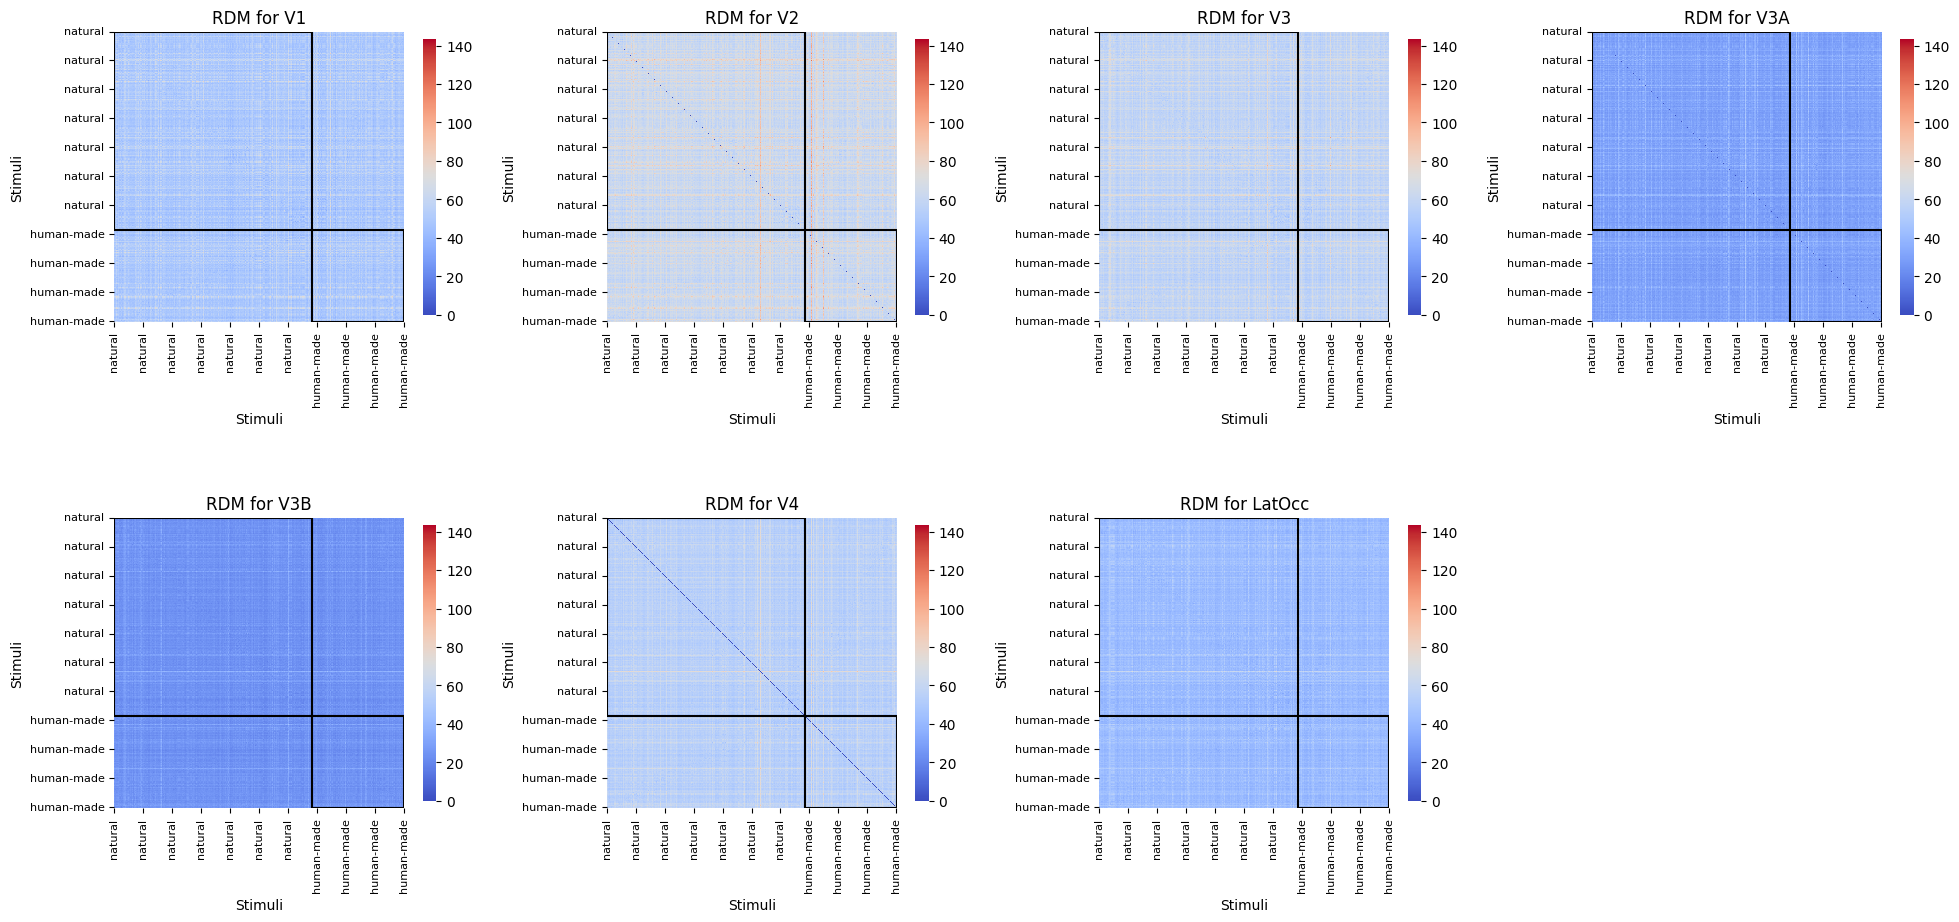

In [17]:
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# Use filtered data from parsed_data
train_labels = np.array([1 if label == 'human-made' else 0 for label in parsed_data_fn_train['label']])
test_labels = np.array([1 if label == 'human-made' else 0 for label in parsed_data_fn_test['label']])

# Create a mapping of labels to indices
label_order = np.argsort(train_labels)
sorted_labels = train_labels[label_order]

# Compute RDM for each ROI with reordered stimuli using filtered data
rdms = {}
for roi_name, responses_roi in roi_responses.items():
    # Filter responses using train_indices and reorder based on sorted labels
    responses_roi_filtered = responses_roi[train_indices]
    responses_roi_sorted = responses_roi_filtered[label_order]

    # Compute the RDM using Euclidean distance
    rdm = scipy.spatial.distance.pdist(responses_roi_sorted, metric='euclidean')
    rdm = scipy.spatial.distance.squareform(rdm)
    rdms[roi_name] = rdm

# Determine indices where the labels change (0=natural, 1=human-made)
change_indices = np.where(np.diff(sorted_labels) != 0)[0] + 1
rdm_values = np.concatenate([rdm.flatten() for rdm in rdms.values()])
vmin = np.min(rdm_values)
vmax = np.max(rdm_values)

# Plotting with consistent color scale
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for ax, (roi_name, rdm) in zip(axes, rdms.items()):
    sns.heatmap(rdm, ax=ax, cmap='coolwarm', square=True, cbar_kws={'shrink': 0.7},
                vmin=vmin, vmax=vmax)
    ax.set_title(f'RDM for {roi_name}', fontsize=12)
    ax.set_xlabel('Stimuli', fontsize=10)
    ax.set_ylabel('Stimuli', fontsize=10)

    ax.tick_params(axis='both', which='major', labelsize=8)

    # Add rectangles for label boundaries
    for idx in change_indices:
        ax.add_patch(Rectangle((0, 0), idx, idx, fill=False, edgecolor='black', lw=1.5))
        ax.add_patch(Rectangle((idx, idx), len(sorted_labels) - idx, len(sorted_labels) - idx,
                             fill=False, edgecolor='black', lw=1.5))

    # Set ticks and labels
    every_nth = max(1, len(sorted_labels) // 10)  # Adjust tick frequency based on data size
    xticks = np.arange(0, len(sorted_labels), every_nth)
    yticks = np.arange(0, len(sorted_labels), every_nth)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(['natural' if l == 0 else 'human-made' for l in sorted_labels[xticks]])
    ax.set_yticklabels(['natural' if l == 0 else 'human-made' for l in sorted_labels[yticks]])

for i in range(len(rdms), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout(pad=2)
plt.show()


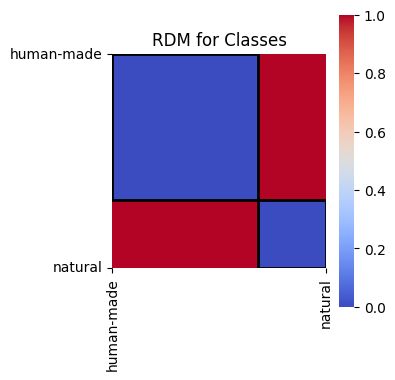

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial.distance

# Use filtered labels from parsed_data
sorted_labels_c = train_labels[label_order]  # Using previously sorted labels

# Create class RDM
class_rdm = scipy.spatial.distance.pdist(sorted_labels_c.reshape(-1, 1), metric='euclidean')
class_rdm = scipy.spatial.distance.squareform(class_rdm)

# Plot with improved visualization
plt.figure(figsize=(4, 4))
sns.heatmap(class_rdm, cmap='coolwarm', cbar=True, square=True)
plt.title("RDM for Classes")

# Get indices where labels change from natural to human-made
change_indices = np.where(np.diff(sorted_labels_c) != 0)[0] + 1

# If there are any changes, use them to place tick marks
if len(change_indices) > 0:
    # Set tick positions at start, change point, and end
    tick_positions = [0, change_indices[0], len(sorted_labels_c)]
    tick_labels = ['human-made', 'natural']

    plt.xticks([0, len(sorted_labels_c)], tick_labels)
    plt.yticks([0, len(sorted_labels_c)], tick_labels)

    # Add rectangles to highlight class boundaries
    plt.gca().add_patch(plt.Rectangle((0, 0), change_indices[0], change_indices[0],
                                    fill=False, edgecolor='black', lw=2))
    plt.gca().add_patch(plt.Rectangle((change_indices[0], change_indices[0]),
                                    len(sorted_labels_c)-change_indices[0],
                                    len(sorted_labels_c)-change_indices[0],
                                    fill=False, edgecolor='black', lw=2))

plt.tight_layout()
plt.show()

In [30]:

def kendall_tau_dissimilarity(matrix1, matrix2):
    """
    Calculates Kendall's Tau correlation between two dissimilarity matrices.

    Args:
        matrix1 (numpy.ndarray): First dissimilarity matrix.
        matrix2 (numpy.ndarray): Second dissimilarity matrix.

    Returns:
        float: Kendall's Tau correlation coefficient.
    """
    upper_triangular1 = np.triu(matrix1, 1)
    upper_triangular2 = np.triu(matrix2, 1)

    flattened1 = upper_triangular1[np.triu_indices(upper_triangular1.shape[0], 1)]
    flattened2 = upper_triangular2[np.triu_indices(upper_triangular2.shape[0], 1)]

    tau, p_value = kendalltau(flattened1, flattened2)

    return tau, p_value


In [31]:
import plotly.graph_objects as go
from scipy.stats import kendalltau
from statsmodels.sandbox.stats.multicomp import multipletests

# Calculate Kendall's Tau and p-values
results = {}
for name, rdm in rdms.items():
    tau, p_value = kendall_tau_dissimilarity(rdm, class_rdm)
    results[name] = (tau, p_value)

# Extract p-values for multiple comparison correction
p_values = [results[name][1] for name in results]

# Multiple comparison correction using Benjamini-Hochberg
reject, p_values_corrected, _, _ = multipletests(
    p_values, method='bonferroni'
)

# Prepare data for plotting
rdm_names = list(results.keys())
taus = [results[name][0] for name in rdm_names]
p_values_corrected = list(p_values_corrected)

# Create bar plot with Plotly
fig = go.Figure()

# Plot Kendall's Tau
fig.add_trace(go.Bar(
    x=rdm_names,
    y=taus,
    name='Kendall\'s Tau',
    marker_color='blue'
))

# Plot corrected p-values
marker_colors = ['green' if p < 0.01 else 'orange' if p < 0.05 else 'red' for p in p_values_corrected]
fig.add_trace(go.Bar(
    x=rdm_names,
    y=p_values_corrected,
    name='P-value (FDR corrected)',
    marker_color=marker_colors
))

# Add significance annotations
for i, name in enumerate(rdm_names):
    x_pos = i
    if p_values_corrected[i] < 0.01:
        fig.add_annotation(
            x=x_pos,
            y=max(taus[i], p_values_corrected[i]) + 0.02,
            text="***",
            showarrow=False,
            font=dict(size=24),
            xref='x',
            yref='y',
            xanchor='center'
        )
    elif p_values_corrected[i] < 0.05:
        fig.add_annotation(
            x=x_pos,
            y=max(taus[i], p_values_corrected[i]) + 0.02,
            text="**",
            showarrow=False,
            font=dict(size=14),
            xref='x',
            yref='y',
            xanchor='center'
        )
    elif p_values_corrected[i] < 0.1:
        fig.add_annotation(
            x=x_pos,
            y=max(taus[i], p_values_corrected[i]) + 0.02,
            text="*",
            showarrow=False,
            font=dict(size=14),
            xref='x',
            yref='y',
            xanchor='center'
        )

fig.update_layout(
    title='Kendall\'s Tau and P-values (FDR corrected) for RDM comparisons between Categorical natural-human-made model and ROI responses',
    xaxis_title='RDM',
    yaxis_title='Values',
    legend=dict(x=0.01, y=0.99),
    barmode='group'
)

fig.show()

In [32]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

def encode_labels(labels):
    unique_labels = np.unique(labels)
    label_to_num = {label: idx for idx, label in enumerate(unique_labels)}
    return np.array([label_to_num[label] for label in labels]), label_to_num

def cross_validate_roi_binary(roi_name, roi_data, labels):
    skf = StratifiedKFold(n_splits=5, shuffle=False)
    metrics = {'accuracy': [], 'auc': [], 'precision': [], 'recall': [], 'f1': [], 'fpr': [], 'tpr': []}

    # Define a common set of thresholds for interpolation
    mean_fpr = np.linspace(0, 1, 100)

    for train_index, test_index in skf.split(roi_data, labels):
        roi_data_train, roi_data_test = roi_data[train_index], roi_data[test_index]
        labels_train, labels_test = labels[train_index], labels[test_index]

        scaler = StandardScaler()
        roi_data_train_normalized = scaler.fit_transform(roi_data_train)
        roi_data_test_normalized = scaler.transform(roi_data_test)

        # Labels are already binary (0/1) from previous filtering
        clf = SVC(kernel='rbf', probability=True, random_state=42)
        clf.fit(roi_data_train_normalized, labels_train)

        predictions = clf.predict(roi_data_test_normalized)
        proba_predictions = clf.predict_proba(roi_data_test_normalized)[:, 1]

        metrics['accuracy'].append(accuracy_score(labels_test, predictions))
        metrics['auc'].append(roc_auc_score(labels_test, proba_predictions))
        metrics['precision'].append(precision_score(labels_test, predictions))
        metrics['recall'].append(recall_score(labels_test, predictions))
        metrics['f1'].append(f1_score(labels_test, predictions))

        fpr, tpr, _ = roc_curve(labels_test, proba_predictions)

        # Interpolate tpr to the common set of thresholds
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0

        metrics['fpr'].append(mean_fpr)
        metrics['tpr'].append(interp_tpr)

    return {k: np.mean(v, axis=0) if k in ['fpr', 'tpr'] else np.mean(v) for k, v in metrics.items()}

# Main analysis using filtered data
results = {}
for roi_name, roi_data in roi_responses.items():
    print(f"\nAnalyzing {roi_name} for human-made vs natural classification:")

    # Use filtered ROI data and binary labels
    filtered_roi_data = roi_data[train_indices]  # Use filtered indices
    filtered_labels = train_labels  # Use binary labels (0/1) created earlier

    if filtered_roi_data.shape[0] < 2:
        print(f"Insufficient data for {roi_name} after filtering. Skipping.")
        continue

    metrics = cross_validate_roi_binary(roi_name, filtered_roi_data, filtered_labels)
    results[roi_name] = metrics
    print(f"Metrics: {metrics}")

# Sort ROIs by AUC score
sorted_rois = sorted(results.items(), key=lambda x: x[1]['auc'], reverse=True)

# Visualize ROC curves
fig = go.Figure()

for roi_name, metrics in sorted_rois:
    fig.add_trace(go.Scatter(
        x=metrics['fpr'],
        y=metrics['tpr'],
        mode='lines',
        name=f"{roi_name} (AUC = {metrics['auc']:.3f})"
    ))

fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(dash='dash'),
    showlegend=False
))

fig.update_layout(
    title='ROC Curves for human-made vs natural Classification Across ROIs',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    width=800,
    height=600
)
fig.show()


Analyzing V1 for human-made vs natural classification:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Metrics: {'accuracy': 0.6780942905517445, 'auc': 0.5063205757372693, 'precision': 0.21818181818181817, 'recall': 0.0037383177570093455, 'f1': 0.007093534212178279, 'fpr': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.6161

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Metrics: {'accuracy': 0.6757326630709883, 'auc': 0.5174847382200481, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'fpr': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Metrics: {'accuracy': 0.6745527220680385, 'auc': 0.5971401617523651, 'precision': 0.2235294117647059, 'recall': 0.009311180339217722, 'f1': 0.01726419481672515, 'fpr': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.6161616

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Nmatchstim
File Stimuli_Trn_FullRes_01.mat does not contain 'stimVal' key
File Stimuli_Trn_FullRes_02.mat does not contain 'stimVal' key
File Stimuli_Trn_FullRes_03.mat does not contain 'stimVal' key
File Stimuli_Trn_FullRes_04.mat does not contain 'stimVal' key
File Stimuli_Trn_FullRes_05.mat does not contain 'stimVal' key
File Stimuli_Trn_FullRes_06.mat does not contain 'stimVal' key
File Stimuli_Trn_FullRes_07.mat does not contain 'stimVal' key
File Stimuli_Trn_FullRes_08.mat does not contain 'stimVal' key
File Stimuli_Trn_FullRes_09.mat does not contain 'stimVal' key
File Stimuli_Trn_FullRes_10.mat does not contain 'stimVal' key
File Stimuli_Trn_FullRes_11.mat does not contain 'stimVal' key
File Stimuli_Trn_FullRes_12.mat does not contain 'stimVal' key
File Stimuli_Trn_FullRes_13.mat does not contain 'stimVal' key
File Stimuli_Trn_F

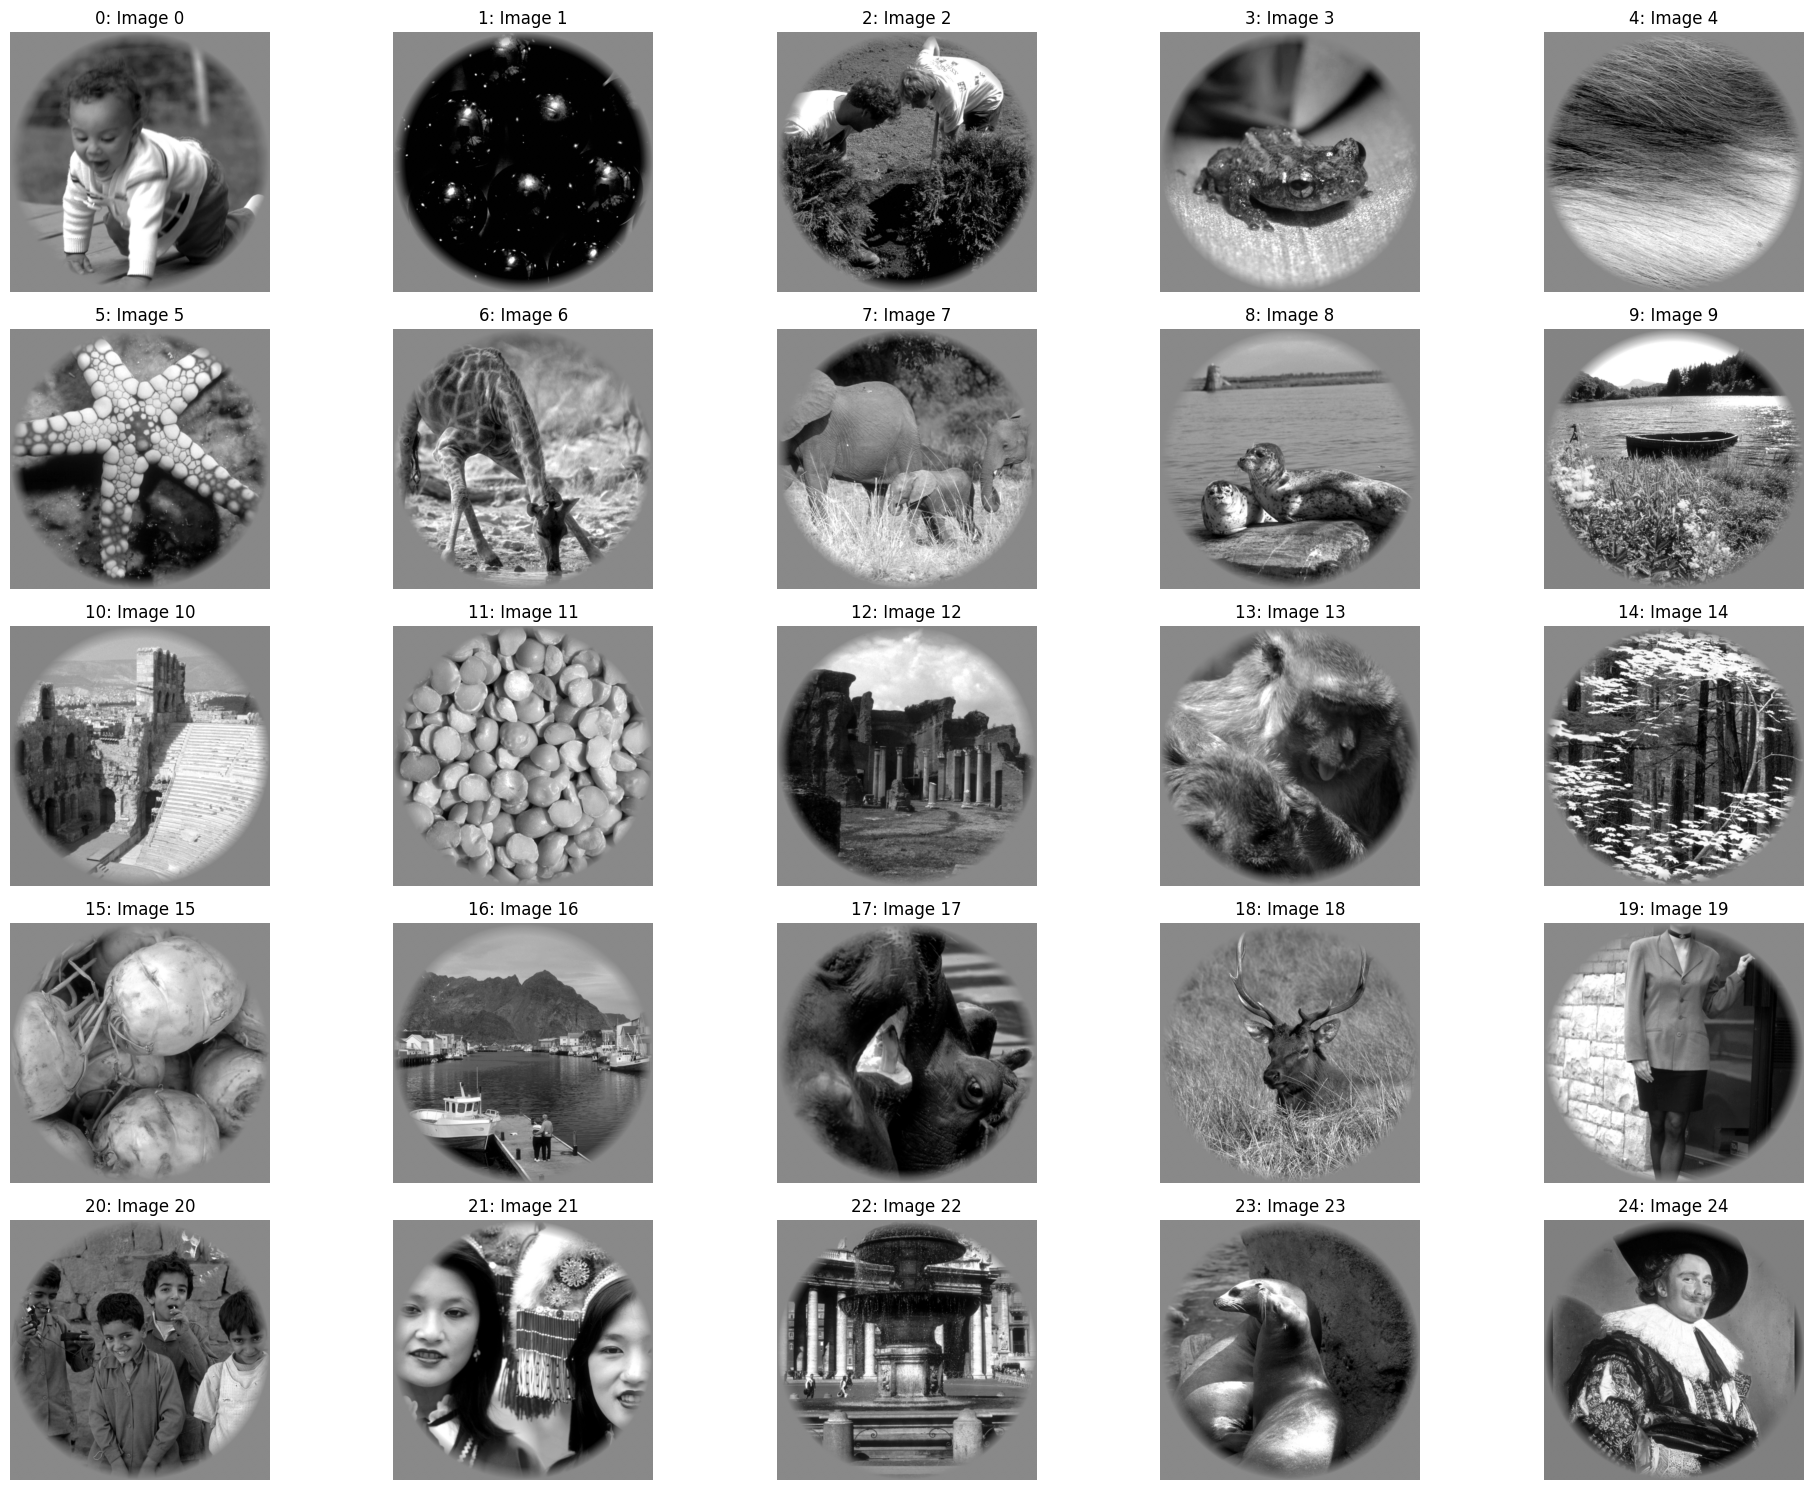

In [33]:
import os
import numpy as np
import scipy.io
import h5py
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/drive')
%cd /content/drive/MyDrive/Nmatchstim

mat_files = [f for f in os.listdir() if f.endswith('.mat')]

loaded_data = {}
all_images_by_file = {}
all_labels = []

if mat_files:
    for filename in mat_files:
        try:
            filepath = filename
            try:
                mat_data = scipy.io.loadmat(filepath)
            except NotImplementedError:
                with h5py.File(filepath, 'r') as f:
                    mat_data = {k: np.array(v) for k, v in f.items()}
            loaded_data[os.path.splitext(filename)[0]] = mat_data
            all_images = []  # Initialize list for images of this file

            # Extract images from 'stimTrn'
            if 'stimTrn' in mat_data:
                value = mat_data['stimTrn']
                try:
                    if isinstance(value, np.ndarray):
                        if value.ndim == 3:
                            for i in range(value.shape[2]):
                                first_channel = value[:, :, i]
                                # Rotate 90 degrees clockwise
                                rotated_image = np.rot90(first_channel, k=-1) # k=-1 is equivalent to 90 degrees clockwise
                                all_images.append(rotated_image)
                except Exception as e:
                    print(f"Could not append image for {filename}, key: stimTrn, Error: {e}")
            else:
                print(f"File {filename} does not contain 'stimTrn' key")

            # Extract images from 'stimVal'
            if 'stimVal' in mat_data:
                value = mat_data['stimVal']
                try:
                    if isinstance(value, np.ndarray):
                        if value.ndim == 3:
                            for i in range(value.shape[2]):
                                first_channel = value[:, :, i]
                                # Rotate 90 degrees clockwise
                                rotated_image = np.rot90(first_channel, k=-1)
                                all_images.append(rotated_image)
                except Exception as e:
                    print(f"Could not append image for {filename}, key: stimVal, Error: {e}")
            else:
                print(f"File {filename} does not contain 'stimVal' key")

            # Attempt to extract labels (assuming 'confidence' or similar key)
            file_labels = []
            for label_key in ['confidence', 'labels']: # Add other potential label keys
                if label_key in mat_data:
                    if isinstance(mat_data[label_key], np.ndarray):
                        # Assuming labels are in a 1D array or need flattening
                        file_labels.extend(mat_data[label_key].flatten().tolist())
                    elif isinstance(mat_data[label_key], list):
                        file_labels.extend(mat_data[label_key])
                    else:
                        print(f"Unexpected format for labels in {filename}, key: {label_key}")
                    break # Stop after finding the first label key
            all_labels.extend(file_labels)

            all_images_by_file[filename] = np.array(all_images) #add to dictionary
        except Exception as e:
            print(f"Error loading file {filename}: {e}")

else:
    print("No .mat files found in the directory")

# Combine all images into a single array
all_images = []
for filename, images in all_images_by_file.items():
  all_images.extend(images) # extend combines elements of a list

res_stim = np.array(all_images)
print(f"Shape of stacked images (res_stim): {res_stim.shape}")

num_images = res_stim.shape[0]
train_size = min(1750, num_images)

train_images = res_stim[:train_size]
test_images = res_stim[train_size:]

print(f"Shape of training images: {train_images.shape}")
print(f"Shape of testing images: {test_images.shape}")

# Try to use extracted labels, otherwise create a placeholder
if all_labels:
    labels = all_labels[:len(res_stim)] # Truncate labels if more than images
    print(f"Number of labels loaded: {len(labels)}")
else:
    print("No labels found in the .mat files. Using placeholder labels.")
    labels = [f"Image {i}" for i in range(len(res_stim))] # Placeholder labels

stimuli = res_stim # Now showing all loaded images (from both stimTrn and stimVal)

slider = 0
plt.figure(figsize=(20, 15))
num_to_show = min(25, len(stimuli))
for i in range(num_to_show):
    plt.subplot(5, 5, i + 1)
    plt.imshow(stimuli[i + slider], cmap='gray')
    if labels:
        plt.title(f"{i + slider}: {labels[i + slider]}")
    else:
        plt.title(f"Image {i + slider}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [34]:
train_images=train_images[train_indices]
test_images=test_images[test_indices - 1750]

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
import numpy as np
from tqdm import tqdm
from torchvision.transforms import functional as TF

def build_alexnet_conv2(device='cuda'):
    alex = models.alexnet(pretrained=True).to(device).eval()
    truncated = nn.Sequential(*list(alex.features.children())[:4])


    return truncated.eval().to(device)

def preprocess_images_for_alexnet(X, device='cuda', apply_circular_mask=True):
    """
    Preprocesses grayscale images for AlexNet, optionally applying a precise circular mask.
    Assumes circles are inscribed within the 500x500 frame.
    """
    # Ensure 3 channels by replicating if necessary
    if X.ndim == 3:
        X = np.repeat(X[:, np.newaxis, :, :], 3, axis=1)
    elif X.shape[1] == 1:
        X = np.repeat(X, 3, axis=1)
    elif X.shape[1] == 3:
        pass
    else:
        raise ValueError(f"Bad shape {X.shape} for input images.")

    if apply_circular_mask:
        H, W = X.shape[-2:]
        center_x, center_y = W // 2, H // 2  # Center of the 500x500 image
        radius = min(center_x, center_y)      # Radius is half the width/height

        y, x = np.ogrid[:H, :W]
        dist_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
        mask = (dist_from_center <= radius).astype(X.dtype)

        # Apply the mask
        if X.ndim == 4:  # (N, C, H, W)
            X = X * mask[np.newaxis, np.newaxis, :, :]
        elif X.ndim == 3: # (N, H, W)
            X = X * mask[np.newaxis, :, :]

    transform_list = [T.ToPILImage(),
                      T.Resize((224, 224)),
                      T.ToTensor(),
                      T.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])]
    transform = T.Compose(transform_list)

    X_torch = torch.from_numpy(X).float()
    N = X_torch.shape[0]

    out_list = []
    for i in range(N):
        img_i = X_torch[i]  # shape (3, H, W)
        tensor_out = transform(img_i)  # => (3,224,224)
        out_list.append(tensor_out)
    final_tensor = torch.stack(out_list, dim=0).to(device)  # => (N,3,224,224)
    return final_tensor

def gaussian_spatial_pool(conv_map, sigma=1.0):
    B, C, H, W = conv_map.shape
    device = conv_map.device
    xs = torch.linspace(-1, 1, W, device=device)
    ys = torch.linspace(-1, 1, H, device=device)
    xv, yv = torch.meshgrid(xs, ys, indexing='xy')
    xv = xv.t()
    yv = yv.t()
    G = torch.exp(- (xv**2 + yv**2)/(2*(sigma**2)))
    G = G / G.sum()
    G_4d = G.unsqueeze(0).unsqueeze(0)
    weighted = conv_map * G_4d
    pooled = weighted.sum(dim=(2,3))
    return pooled

def extract_conv2_features_gaussian(
    images,
    model_conv2,
    sigma=1.0,
    chunk_size=16,
    device='cuda',
    apply_circular_mask=True,
    pooling='gaussian' # Added pooling option
):
    N = images.shape[0]
    preprocessed = preprocess_images_for_alexnet(images, device=device, apply_circular_mask=apply_circular_mask)

    feats = []
    indices = np.arange(N)
    start = 0
    with torch.no_grad():
        while start < N:
            end = min(start + chunk_size, N)
            batch_idx = indices[start:end]
            batch_data = preprocessed[batch_idx]

            conv_map = model_conv2(batch_data)

            if pooling == 'gaussian':
                pooled = gaussian_spatial_pool(conv_map, sigma=sigma)
            elif pooling == 'none':
                pooled = conv_map.flatten(start_dim=1)
            else:
                raise ValueError(f"Unknown pooling method: {pooling}")

            feats.append(pooled.cpu().numpy())
            start = end

    feats_all = np.concatenate(feats, axis=0)
    return feats_all

if __name__ == "__main__":
    model_conv2 = build_alexnet_conv2(device='cuda')

    # Extract features with circular mask
    feats_train = extract_conv2_features_gaussian(
        train_images,
        model_conv2,
        sigma=1.0,
        chunk_size=16,
        device='cuda',
        apply_circular_mask=True,
        pooling='none'
    )
    print("Gaussian-pooled conv1 feats (train, masked):", feats_train.shape)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.



Gaussian-pooled conv1 feats (train, masked): (1693, 139968)


In [36]:
from scipy.stats import spearmanr
import numpy as np

def calculate_rdm(data):
    """Calculates a Representational Dissimilarity Matrix (RDM)."""
    return 1 - np.corrcoef(data)

def compare_rdms(rdm1, rdm2):
    """Compares two RDMs using Spearman rank correlation."""
    rdm1_flat = rdm1[np.triu_indices(rdm1.shape[0], k=1)]
    rdm2_flat = rdm2[np.triu_indices(rdm2.shape[0], k=1)]
    rho, pval = spearmanr(rdm1_flat, rdm2_flat)
    return rho

# Use train_indices to filter the ROI responses
filtered_roi_responses = {}
for roi_name, roi_data in roi_responses.items():
    filtered_roi_responses[roi_name] = roi_data[train_indices]

# Calculate the RDM based on filtered Gabor features
gabor_rdm = calculate_rdm(feats_train[label_order])

results_rsa = {}
for roi_name, neural_rdm in rdms.items():
    # Compare the neural RDM with the Alexnet feature rdm
    rho = compare_rdms(neural_rdm, gabor_rdm)
    results_rsa[roi_name] = rho

# Create a Pandas DataFrame for easier viewing
results_df_rsa = pd.DataFrame.from_dict(results_rsa, orient='index', columns=['Spearman_rho'])
print(results_df_rsa)

        Spearman_rho
V1          0.099292
V2          0.110221
V3          0.063480
V3A         0.002190
V3B         0.028902
V4          0.040673
LatOcc      0.013714


In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
import numpy as np
from tqdm import tqdm
from torchvision.transforms import functional as TF
from scipy.stats import spearmanr
import pandas as pd
import cv2

class LateralInhibitionPooling(nn.Module):
    def __init__(self, inhibition_radius=3, inhibition_strength=0.5):
        super(LateralInhibitionPooling, self).__init__()
        self.inhibition_radius = inhibition_radius
        self.inhibition_strength = inhibition_strength
        self.pool = nn.AvgPool2d(kernel_size=inhibition_radius, stride=1, padding=inhibition_radius//2)

    def forward(self, x):
        inhibition = self.pool(x)
        return x - self.inhibition_strength * inhibition

# Modify build_alexnet_features to include LRN after first ReLU
def build_alexnet_features(layer_idx, device='cuda'):
    alex = models.alexnet(pretrained=True).to(device).eval()
    layers = []
    for i in range(layer_idx + 1):
        layer = alex.features[i]
        layers.append(layer)
        if i == 1:
            # Insert LRN after relu1
            layers.append(nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2))
    truncated = nn.Sequential(*layers)
    return truncated.eval().to(device)

# Function to generate Gabor filters
def generate_gabor_filters(num_filters, kernel_size=11):
    filters = []
    for _ in range(num_filters):
        theta = np.random.uniform(0, 180)
        freq = np.random.uniform(0.1, 0.5)
        kern = cv2.getGaborKernel((kernel_size, kernel_size), 1.0, theta, freq, 0.5, 0, ktype=cv2.CV_32F)
        kern = torch.from_numpy(kern).unsqueeze(0).unsqueeze(0).float()  # Shape: [1, 1, 11, 11]
        kern = kern.repeat(1, 3, 1, 1)  # Shape: [1, 3, 11, 11]
        filters.append(kern)
    filters = torch.cat(filters, dim=0)  # Shape: [num_filters, 3, 11, 11]
    return filters

# Update extract_features to handle lateral inhibition pooling
def extract_features(
    images,
    model,
    chunk_size=16,
    device='cuda',
    apply_circular_mask=True,
    pooling='none',
    sigma=1.0
):
    N = images.shape[0]
    preprocessed = preprocess_images_for_alexnet(images, device=device, apply_circular_mask=apply_circular_mask)

    feats = []
    indices = np.arange(N)
    start = 0
    with torch.no_grad():
        while start < N:
            end = min(start + chunk_size, N)
            batch_idx = indices[start:end]
            batch_data = preprocessed[batch_idx]

            feature_map = model(batch_data)

            if pooling == 'gaussian':
                pooled = gaussian_spatial_pool(feature_map, sigma=sigma)
            elif pooling == 'none':
                pooled = feature_map.flatten(start_dim=1)
            elif pooling == 'max':
                pooled = F.adaptive_max_pool2d(feature_map, (1, 1)).flatten(start_dim=1)
            elif pooling == 'avg':
                pooled = F.adaptive_avg_pool2d(feature_map, (1, 1)).flatten(start_dim=1)
            elif pooling == 'lateral_inhibition':
                pooling_layer = LateralInhibitionPooling(inhibition_radius=3, inhibition_strength=0.5)
                pooled = pooling_layer(feature_map).flatten(start_dim=1)
            else:
                raise ValueError(f"Unknown pooling method: {pooling}")

            feats.append(pooled.cpu().numpy())
            start = end

    feats_all = np.concatenate(feats, axis=0)
    return feats_all

# Set sigma values for Gaussian pooling
sigma_values_to_test = [0.5, 0.75, 1.0, 1.25]

# Update search_alexnet_layers_and_pooling to include lateral inhibition and sigma values
def search_alexnet_layers_and_pooling(
    images,
    roi_responses,
    rdms,
    train_indices,
    label_order,
    layer_indices,
    pooling_methods,
    sigma_values=None,
    chunk_size=16,
    device='cuda',
    apply_circular_mask=True
):
    results = []

    # Filter ROI responses based on train_indices
    filtered_roi_responses = {
        roi_name: roi_data[train_indices] for roi_name, roi_data in roi_responses.items()
    }

    for layer_idx in tqdm(layer_indices, desc="Layers"):
        model = build_alexnet_features(layer_idx, device=device)

        if layer_idx >= 0:
            gabor_filters = generate_gabor_filters(num_filters=64, kernel_size=11)
            model[0].weight.data.copy_(gabor_filters)
            model[0].requires_grad_(False)

        for pooling in tqdm(pooling_methods, desc="Pooling", leave=False):
            sigmas_to_use = sigma_values if pooling == "gaussian" and sigma_values is not None else [None]

            for sigma in sigmas_to_use:
                feats_train = extract_features(
                    images,
                    model,
                    chunk_size=chunk_size,
                    device=device,
                    apply_circular_mask=apply_circular_mask,
                    pooling=pooling,
                    sigma=sigma
                )

                model_rdm = calculate_rdm(feats_train[label_order])

                for roi_name, neural_rdm in rdms.items():
                    rho = compare_rdms(neural_rdm, model_rdm)
                    results.append(
                        {
                            "layer_idx": layer_idx,
                            "pooling": pooling,
                            "sigma": sigma,
                            "roi": roi_name,
                            "rho": rho,
                        }
                    )

    return pd.DataFrame(results)

In [41]:
import numpy as np
import numpy.linalg as la
from scipy.stats import f
from sklearn.decomposition import PCA

def mdmr(D, X, n_permutations=0, random_state=None):
    """
    Perform Multivariate Distance Matrix Regression (MDMR).
    D: NxN distance matrix
    X: NxM design (already includes intercept if desired)
    If n_permutations = 0, we return the parametric F-based p-value.
    """
    N = D.shape[0]
    assert D.shape[1] == N, "Distance matrix must be NxN."

    # Center the distance matrix
    A = -0.5 * (D**2)
    I = np.eye(N)
    ones = np.ones((N, N)) / N
    Hc = I - ones
    G = Hc @ A @ Hc

    # Compute F-statistic
    XtX = X.T @ X
    XtX_inv = la.inv(XtX)
    H = X @ (XtX_inv @ X.T)

    df1 = np.linalg.matrix_rank(X)
    df2 = N - df1

    num = np.trace(H @ G @ H)
    den = np.trace((I - H) @ G @ (I - H))
    F_val = (num / df1) / (den / df2)

    if n_permutations > 0:
        # Permutation test code omitted for param approach
        # We'll skip permutations and just compute param p-values
        pass

    # Parametric p_val from the F distribution:
    p_val = 1.0 - f.cdf(F_val, df1, df2)

    return F_val, p_val

def mdmr_diff_test_param(D, X_reduced, X_full):
    """
    Parametric version of difference-based MDMR:
      1) MDMR for X_reduced -> (F_reduced, p_reduced)
      2) MDMR for X_full    -> (F_full, p_full)
      3) deltaF = F_full - F_reduced
    Note: There's no direct parametric p_val for deltaF in MDMR.
    """
    # Step 1: MDMR for reduced (parametric p-value)
    F_reduced, p_reduced = mdmr(D, X_reduced, n_permutations=0)

    # Step 2: MDMR for full (parametric p-value)
    F_full, p_full = mdmr(D, X_full, n_permutations=0)

    deltaF = F_full - F_reduced

    return {
        "F_reduced": F_reduced,
        "p_reduced": p_reduced,
        "F_full": F_full,
        "p_full": p_full,
        "deltaF": deltaF
    }

N_train = len(y_train)
gabor_train_sorted = feats_train[label_order]
human_made_sorted = sorted_labels_c  # shape (n_conditions,)

pca = PCA(n_components=100, random_state=42)
gabor_train_reduced = pca.fit_transform(gabor_train_sorted)

X_reduced = np.column_stack([
    np.ones(N_train),
    gabor_train_reduced
])

X_full = np.column_stack([
    X_reduced,
    human_made_sorted
])

mdmr_diff_param_results = {}

for roi_name, rdm in rdms.items():
    results = mdmr_diff_test_param(rdm, X_reduced, X_full)
    mdmr_diff_param_results[roi_name] = results

print("\n=== Parametric MDMR: Reduced vs. Full ===")
for roi_name, vals in mdmr_diff_param_results.items():
    print(f"\nROI: {roi_name}")
    print(f"  F_reduced: {vals['F_reduced']:.4f}, p_reduced: {vals['p_reduced']:.5g}")
    print(f"  F_full   : {vals['F_full']:.4f}, p_full   : {vals['p_full']:.5g}")
    print(f"  deltaF   : {vals['deltaF']:.4f}")



=== Parametric MDMR: Reduced vs. Full ===

ROI: V1
  F_reduced: 1.4882, p_reduced: 0.0016018
  F_full   : 1.4849, p_full   : 0.0016246
  deltaF   : -0.0033

ROI: V2
  F_reduced: 1.3522, p_reduced: 0.013362
  F_full   : 1.3515, p_full   : 0.013171
  deltaF   : -0.0007

ROI: V3
  F_reduced: 1.1828, p_reduced: 0.10973
  F_full   : 1.1852, p_full   : 0.10612
  deltaF   : 0.0023

ROI: V3A
  F_reduced: 1.0862, p_reduced: 0.26787
  F_full   : 1.0948, p_full   : 0.24907
  deltaF   : 0.0086

ROI: V3B
  F_reduced: 1.1413, p_reduced: 0.16585
  F_full   : 1.1545, p_full   : 0.14509
  deltaF   : 0.0132

ROI: V4
  F_reduced: 1.1270, p_reduced: 0.18934
  F_full   : 1.1324, p_full   : 0.1792
  deltaF   : 0.0054

ROI: LatOcc
  F_reduced: 1.1335, p_reduced: 0.1783
  F_full   : 1.1417, p_full   : 0.16421
  deltaF   : 0.0082


In [42]:
import numpy as np
import numpy.linalg as la
from scipy.stats import f
from sklearn.decomposition import PCA

def partial_mdmr(D, X_gabor, X_humanmade, n_permutations=0, random_state=None):
    """
    Partial (Incremental) MDMR:
      1) Residualize the centered distance matrix G with respect to X_gabor
      2) Run MDMR on the residual matrix using X_humanmade
      3) If n_permutations > 0, shuffle the rows of X_humanmade to derive a permutation-based p-value

    Args:
      D : NxN distance matrix
      X_gabor : NxM design matrix for Gabor features (could include intercept as first column)
      X_humanmade : NxK design matrix for human-made factor(s) (e.g., Nx2 if it includes an intercept column)
      n_permutations : number of permutations for shuffling X_humanmade to get a robust p-value
      random_state : seed for reproducibility

    Returns:
      F_val : partial MDMR F statistic for human-made
      p_val : p-value (parametric if n_permutations=0, or permutation-based if >0)
    """
    # Ensure the distance matrix is NxN
    N = D.shape[0]
    assert D.shape[1] == N, "Distance matrix must be NxN."

    # Step 1: Construct the centered distance matrix G = Hc A Hc, where A = -0.5 * D^2
    A = -0.5 * (D ** 2)
    I = np.eye(N)
    Hc = I - np.ones((N, N)) / N
    G = Hc @ A @ Hc  # NxN

    # Step 2: Residualize G with respect to X_gabor
    #   H_gabor = X_gabor (X_gabor^T X_gabor)^-1 X_gabor^T
    #   Gres = (I - H_gabor) G (I - H_gabor)
    XtX_g = X_gabor.T @ X_gabor
    XtX_g_inv = la.inv(XtX_g)
    H_gabor = X_gabor @ (XtX_g_inv @ X_gabor.T)
    I_minus_Hg = I - H_gabor
    Gres = I_minus_Hg @ G @ I_minus_Hg

    # Helper to compute the partial MDMR F statistic given Gres and X_humanmade
    def compute_f_val(G_matrix, X_design):
        df1 = np.linalg.matrix_rank(X_design)
        df2 = N - df1

        XtX = X_design.T @ X_design
        XtX_inv = la.inv(XtX)
        H_ani = X_design @ (XtX_inv @ X_design.T)

        num = np.trace(H_ani @ G_matrix @ H_ani)
        den = np.trace((I - H_ani) @ G_matrix @ (I - H_ani))
        F_val_local = (num / df1) / (den / df2)
        return F_val_local, df1, df2

    # Compute partial MDMR F-value (human-made over Gabor)
    F_val, df1_ani, df2_ani = compute_f_val(Gres, X_humanmade)

    # Step 3: Permutation-based p-value if requested
    if n_permutations > 0:
        rng = np.random.default_rng(random_state)
        perm_count = 0
        for _ in range(n_permutations):
            # Shuffle entire rows of X_humanmade
            perm_idx = rng.permutation(N)
            X_shuf = X_humanmade[perm_idx, :]

            F_shuf, _, _ = compute_f_val(Gres, X_shuf)
            if F_shuf >= F_val:
                perm_count += 1
        p_val = (perm_count + 1) / (n_permutations + 1)
    else:
        # Parametric approach for partial MDMR
        p_val = 1.0 - f.cdf(F_val, df1_ani, df2_ani)

    return F_val, p_val


# -----------------------------
# Example usage for each ROI
# -----------------------------
# 1) Build a "Gabor" design matrix (e.g., NxM) including an intercept
# 2) Build an "human-made" design matrix (Nx2 if you want intercept + human-made_col)

N_train = len(y_train)
gabor_train_sorted = feats_train[label_order]  # shape: (N, features)
human_made_sorted = sorted_labels_c               # shape: (N, ) for 0/1

# Example: PCA on Gabor
pca = PCA(n_components=100, random_state=42)
gabor_train_reduced = pca.fit_transform(gabor_train_sorted)

# Gabor design + intercept
X_gabor = np.column_stack([
    np.ones(N_train),
    gabor_train_reduced
])

# human-made design: intercept + human-made_sorted
X_humanmade = np.column_stack([
    np.ones(N_train),
    human_made_sorted
])

# Now, for each ROI, run partial MDMR
partial_mdmr_results = {}
n_permutations = 1000  # choose how many permutations you want for robust p-values

for roi_name, rdm in rdms.items():
    F_partial, p_partial = partial_mdmr(
        rdm,
        X_gabor,
        X_humanmade,
        n_permutations=n_permutations,
        random_state=42
    )
    partial_mdmr_results[roi_name] = (F_partial, p_partial)

# Print results
print("\n=== Partial MDMR: human-made Over Gabor ===")
for roi_name, (F_val, p_val) in partial_mdmr_results.items():
    print(f"\nROI: {roi_name}")
    print(f"  F_partial: {F_val:.4f}, p_partial: {p_val:.5g}")



=== Partial MDMR: human-made Over Gabor ===

ROI: V1
  F_partial: 0.3881, p_partial: 0.97103

ROI: V2
  F_partial: 0.4286, p_partial: 0.8971

ROI: V3
  F_partial: 0.4744, p_partial: 0.5974

ROI: V3A
  F_partial: 0.6473, p_partial: 0.066933

ROI: V3B
  F_partial: 0.8148, p_partial: 0.011988

ROI: V4
  F_partial: 0.5579, p_partial: 0.12787

ROI: LatOcc
  F_partial: 0.6488, p_partial: 0.033966


In [43]:
import logging
from joblib import Parallel, delayed
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Set up logging to monitor progress
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s:%(message)s')

def variance_partitioning(roi_data, gabor_features, labels, use_pca=False, n_components=50, n_jobs=2, batch_size=1000):
    """
    For each voxel (column) in roi_data, fit a full linear model using a design matrix that
    combines gabor_features and labels, and a reduced model using only gabor_features.
    The unique variance explained by the label is calculated as the difference in R².
    Processes voxels in batches to reduce memory load.
    """
    # Scale ROI data
    scaler = StandardScaler()
    roi_data_scaled = scaler.fit_transform(roi_data)

    # Optionally reduce dimensionality of gabor_features
    if use_pca:
        pca = PCA(n_components=n_components, random_state=42)
        gabor_features = pca.fit_transform(gabor_features)

    # Build design matrix: combine gabor features and binary labels (ensuring labels are a column vector)
    X_full = np.column_stack((gabor_features, labels.reshape(-1, 1)))

    n_voxels = roi_data_scaled.shape[1]
    logging.info(f"Starting variance partitioning on {n_voxels} voxels...")

    # Process voxels in batches
    def process_batch(start_idx, end_idx):
        batch_results = []
        for v in range(start_idx, end_idx):
            y = roi_data_scaled[:, v]
            # Full model: using Gabor features + label
            full_model = LinearRegression()
            full_model.fit(X_full, y)
            r2_full = r2_score(y, full_model.predict(X_full))
            # Reduced model: using only Gabor features
            reduced_model = LinearRegression()
            reduced_model.fit(gabor_features, y)
            r2_reduced = r2_score(y, reduced_model.predict(gabor_features))
            unique_variance = max(r2_full - r2_reduced, 0)
            batch_results.append(unique_variance)
            if (v - start_idx) % 100 == 0:
                logging.info(f"Processed voxel {v}/{end_idx}")
        return batch_results

    # Create a list of batches
    batches = [(i, min(i + batch_size, n_voxels)) for i in range(0, n_voxels, batch_size)]

    # Use Parallel to process each batch concurrently
    results_list = Parallel(n_jobs=n_jobs)(delayed(process_batch)(start, end) for start, end in batches)

    # Flatten the list
    prop_variance_explained = np.concatenate(results_list)
    mean_explained = np.mean(prop_variance_explained)
    logging.info(f"Finished variance partitioning: mean unique variance explained = {mean_explained:.4f}")

    return {
        'prop_variance_explained': prop_variance_explained,
        'prop_variance_explained_mean': mean_explained
    }

# Example usage:
var_metrics = variance_partitioning(filtered_roi_data, feats_train, y_train, use_pca=True, n_jobs=2, batch_size=1000)



In [44]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# --- Step 1: Compute voxel_data per ROI if not already defined ---
if 'voxel_data' not in globals():
    voxel_data = {}
    print("Computing variance partitioning for each ROI...")
    for roi_name, roi_data in filtered_roi_responses.items():
        print(f"Processing ROI: {roi_name}...")
        # Compute variance partitioning for the current ROI.
        # (Assumes that feats_train and y_train are defined and represent the full feature set and labels.)
        var_metrics_roi = variance_partitioning(roi_data, feats_train, y_train, use_pca=True, n_jobs=2, batch_size=1000)
        # Store the per-voxel unique variance explained (an array) under the ROI name.
        voxel_data[roi_name] = var_metrics_roi['prop_variance_explained']
    print("Finished computing variance partitioning for all ROIs.")

# --- Step 2: Build a DataFrame from voxel_data for visualization ---
roi_names = []
unique_variances = []
for roi, var_values in voxel_data.items():
    roi_names.extend([roi] * len(var_values))
    unique_variances.extend(var_values)

df_variance = pd.DataFrame({
    'ROI': roi_names,
    'UniqueVariance': unique_variances
})

# --- Step 3: Create a Violin Plot ---
fig_violin = px.violin(
    df_variance,
    x="ROI",
    y="UniqueVariance",
    box=True,
    points="all",
    title="Distribution of Unique Variance Explained Across ROIs",
    labels={"UniqueVariance": "Unique Variance Explained (ΔR²)"}
)
fig_violin.update_layout(template="plotly_white")
fig_violin.show()

# --- Step 4: Bar Plot of Mean Unique Variance Explained per ROI ---
mean_variance = df_variance.groupby("ROI")["UniqueVariance"].mean().reset_index()
fig_bar = px.bar(
    mean_variance,
    x="ROI",
    y="UniqueVariance",
    title="Mean Unique Variance Explained by ROI",
    labels={"UniqueVariance": "Mean Unique Variance Explained (ΔR²)"}
)
fig_bar.update_layout(template="plotly_white")
fig_bar.show()

# --- Step 5: Scatter Plot Comparing RSA vs. Mean Unique Variance (if RSA results exist) ---
if 'results_df_rsa' in globals():
    df_rsa = results_df_rsa.reset_index().rename(columns={"index": "ROI", "Spearman_rho": "RSA"})
    # Merge the mean variance data with RSA results on ROI name.
    df_merge = pd.merge(mean_variance, df_rsa, on="ROI", how="inner")

    fig_scatter = px.scatter(
        df_merge,
        x="RSA",
        y="UniqueVariance",
        text="ROI",
        title="RSA vs. Mean Unique Variance Explained by ROI",
        labels={
            "RSA": "RSA Correlation (Spearman Rho)",
            "UniqueVariance": "Mean Unique Variance Explained (ΔR²)"
        }
    )
    fig_scatter.update_traces(textposition='top center')
    fig_scatter.update_layout(template="plotly_white")
    fig_scatter.show()
else:
    print("RSA results not defined; skipping RSA scatter plot.")


Computing variance partitioning for each ROI...
Processing ROI: V1...
Processing ROI: V2...
Processing ROI: V3...
Processing ROI: V3A...
Processing ROI: V3B...
Processing ROI: V4...
Processing ROI: LatOcc...
Finished computing variance partitioning for all ROIs.


In [45]:
# %% [code]
print("========== PROJECT SUMMARY ==========\n")

# --- 1. Data Acquisition & Preprocessing ---
print("1. Data Acquisition & Preprocessing:")
print(f"   X_train shape: {X_train.shape}")
print(f"   X_test shape: {X_test.shape}")
print(f"   y_train shape: {y_train.shape}")
print(f"   y_test shape: {y_test.shape}\n")

print("   ROI Voxel Counts:")
for roi, count in roi_counts.items():
    print(f"     {roi}: {count}")

print("\n   Mean Voxel Responses per ROI:")
for roi, mean_val in roi_mean_responses.items():
    print(f"     {roi}: {mean_val:.4f}")

# --- 2. Representational Dissimilarity (RDM) Analysis ---
print("\n2. Representational Dissimilarity (RDM) Analysis:")
# Recompute Kendall's Tau for each ROI vs. the class RDM if not already stored
kendall_results = {}
for roi_name, rdm in rdms.items():
    tau, p_val = kendall_tau_dissimilarity(rdm, class_rdm)
    kendall_results[roi_name] = (tau, p_val)

print("   Kendall's Tau (RDM vs. Class RDM):")
for roi, (tau, p_val) in kendall_results.items():
    print(f"     {roi}: Tau = {tau:.4f}, p-value = {p_val:.5g}")

# --- 3. Classification Analysis (human-made vs. natural) ---
print("\n3. Classification Analysis (human-made vs. natural):")
# Here we expect 'results' to be a dictionary mapping ROI names to a dict of metrics.
if isinstance(results, dict) and results:
    sample_val = next(iter(results.values()))
    if isinstance(sample_val, dict) and 'accuracy' in sample_val:
        for roi, metrics in results.items():
            print(f"   ROI: {roi}")
            print(f"     Accuracy : {metrics['accuracy']:.4f}")
            print(f"     AUC      : {metrics['auc']:.4f}")
            print(f"     Precision: {metrics['precision']:.4f}")
            print(f"     Recall   : {metrics['recall']:.4f}")
            print(f"     F1 Score : {metrics['f1']:.4f}")
    else:
        print("   [Warning] 'results' variable is not in the expected format for classification metrics.")
else:
    print("   [Warning] Classification results not found or 'results' variable is not defined as expected.")

# --- 4. Feature Extraction with AlexNet ---
print("\n4. Feature Extraction with AlexNet:")
print(f"   Extracted features shape (feats_train): {feats_train.shape}")

# --- 5. Representational Similarity Analysis (RSA) ---
print("\n5. Representational Similarity Analysis (RSA):")
print("   Spearman Rho between neural and Gabor RDMs (per ROI):")
if 'results_df_rsa' in globals():
    print(results_df_rsa.to_string())
else:
    print("   [Warning] RSA results DataFrame 'results_df_rsa' not found.")

# --- 6. Multivariate Distance Matrix Regression (MDMR) Analysis ---
print("\n6. MDMR Analysis (Parametric: Reduced vs. Full):")
if 'mdmr_diff_param_results' in globals():
    for roi, vals in mdmr_diff_param_results.items():
        print(f"   ROI: {roi}")
        print(f"     F_reduced: {vals['F_reduced']:.4f}, p_reduced: {vals['p_reduced']:.5g}")
        print(f"     F_full   : {vals['F_full']:.4f}, p_full   : {vals['p_full']:.5g}")
        print(f"     deltaF   : {vals['deltaF']:.4f}")
else:
    print("   [Warning] MDMR results 'mdmr_diff_param_results' not found.")

print("\n   Partial MDMR (human-made over Gabor):")
if 'partial_mdmr_results' in globals():
    for roi, (F_val, p_val) in partial_mdmr_results.items():
        print(f"   ROI: {roi}")
        print(f"     F_partial: {F_val:.4f}, p_partial: {p_val:.5g}")
else:
    print("   [Warning] Partial MDMR results 'partial_mdmr_results' not found.")

# --- 7. Variance Partitioning ---
print("\n7. Variance Partitioning (Unique Variance Explained by human-made Label):")
if 'mean_variance' in globals():
    print("   Mean Unique Variance per ROI:")
    print(mean_variance.to_string(index=False))
else:
    print("   [Warning] Mean variance data 'mean_variance' not found.")

print("\n========== END OF SUMMARY ==========")



========== PROJECT SUMMARY ==========

1. Data Acquisition & Preprocessing:
   X_train shape: (1693, 128, 128)
   X_test shape: (118, 128, 128)
   y_train shape: (1693,)
   y_test shape: (118,)

   ROI Voxel Counts:
     Other: 0
     V1: 1294
     V2: 2083
     V3: 1790
     V3A: 484
     V3B: 314
     V4: 1535
     LatOcc: 928

   Mean Voxel Responses per ROI:
     V1: 0.0000
     V2: 0.0000
     V3: 0.0000
     V3A: 0.0000
     V3B: 0.0000
     V4: 0.0000
     LatOcc: 0.0000

2. Representational Dissimilarity (RDM) Analysis:
   Kendall's Tau (RDM vs. Class RDM):
     V1: Tau = 0.0199, p-value = 1.6348e-186
     V2: Tau = 0.0161, p-value = 1.007e-122
     V3: Tau = 0.0126, p-value = 9.0128e-76
     V3A: Tau = 0.0038, p-value = 3.1988e-08
     V3B: Tau = 0.0130, p-value = 2.9664e-81
     V4: Tau = 0.0094, p-value = 4.4356e-43
     LatOcc: Tau = 0.0097, p-value = 9.7533e-46

3. Classification Analysis (human-made vs. natural):
   [Warning] 'results' variable is not in the expected form

In [46]:
#MDMR plot with the same results results copied from above cell results to avoid doing the permutations again which takes a long time to fully run

import pandas as pd
import plotly.graph_objects as go
from statsmodels.sandbox.stats.multicomp import multipletests

# Data for Partial MDMR (human-made/natural)
data = {
    'ROI': ['V1', 'V2', 'V3', 'V3A', 'V3B', 'V4', 'LatOcc'],
    'F_partial': [0.3881, 0.4286, 0.4744, 0.6473, 0.8148, 0.5579, 0.6488],
    'p_partial': [0.97103, 0.8971, 0.5974, 0.066933, 0.011988, 0.12787, 0.033966]
}
df = pd.DataFrame(data)

# Perform multiple comparison correction using FDR (Benjamini–Hochberg)
p_vals = df['p_partial'].values
reject, p_values_corrected, _, _ = multipletests(p_vals, method='fdr_bh')
df['p_corrected'] = p_values_corrected

# Prepare data for plotting
roi_names = df['ROI'].tolist()
F_values = df['F_partial'].tolist()
p_values = df['p_corrected'].tolist()

# Define marker colors for corrected p-values based on significance thresholds
p_marker_colors = [
    'green' if p < 0.01 else 'orange' if p < 0.05 else 'red'
    for p in p_values
]

# Create the Plotly figure
fig = go.Figure()

# Trace for Partial MDMR F-values
fig.add_trace(go.Bar(
    x=roi_names,
    y=F_values,
    name="Partial MDMR F-Value",
    marker_color='blue',
    hovertemplate='<b>%{x}</b><br>F-Value: %{y:.3f}<extra></extra>'
))

# Trace for corrected p-values using FDR correction
fig.add_trace(go.Bar(
    x=roi_names,
    y=p_values,
    name="P-value (FDR corrected)",
    marker_color=p_marker_colors,
    hovertemplate='<b>%{x}</b><br>p-value: %{y:.3f}<extra></extra>'
))

# Add significance annotations above each ROI
for i, roi in enumerate(roi_names):
    if p_values[i] < 0.001:
        sig_text = '***'
    elif p_values[i] < 0.01:
        sig_text = '**'
    elif p_values[i] < 0.05:
        sig_text = '*'
    else:
        sig_text = ''

    if sig_text:
        # Place annotation slightly above the maximum of F-value and corrected p-value for clarity
        annot_y = max(F_values[i], p_values[i]) + 0.05
        fig.add_annotation(
            x=roi,
            y=annot_y,
            text=sig_text,
            showarrow=False,
            font=dict(size=18, color='black'),
            xref='x',
            yref='y',
            xanchor='center'
        )

# Customize layout
fig.update_layout(
    title="Partial MDMR Results: human-made/natural Category (Controlling for Low-Level Features)",
    xaxis_title="ROI",
    yaxis_title="Value",
    barmode='group',
    legend=dict(x=0.01, y=0.99),
    template="plotly_white"
)

fig.show()


